In [4]:
import sympy as sym
import numpy as np
from sympy import symbols, Eq, Matrix
import matplotlib.pyplot as plt
from scipy.linalg import ordqz, inv, qz

# Sims 1999

$$\Gamma_0 y_t=\Gamma_1 y_{t-1}+C+\Psi z_t+\Pi\eta_t$$
For the moment, assume $\Gamma_0$ is invertible

$$y_t=\Theta_1 y_{t-1}+\Theta_0 z_t+\Theta_C C$$

In [5]:
def custom_sympy(eq,symbols):
    d={i:sym.symbols(i) for i in symbols.split()}
    return sym.Eq(*[eval(i,d) for i in eq.split('=')])

custom_sympy('a+b=4+c', 'a b c')

Eq(a + b, c + 4)

In [103]:
class prova:
    def __init__(self, equations, variables, shocks, parameters):
        self.y = {v:symbols(v) for v in variables.replace(" ", "").split(',')}
        self.y_ = {v.replace('t','t-1'):symbols(v.replace('t','t-1')) for v in variables.replace(" ", "").split(',')}
        #self.equations = {Eq(*[eval(i) for i in eq.split('=')]) for eq in equations}
        pass

In [125]:
class prova:
    def __init__(self, variables, equations):
        self.y = {v:symbols(v) for v in variables.replace(" ", "").split(',')}
        self.y_ = {v.replace('t','t-1'):symbols(v.replace('t','t-1')) for v in self.y.keys()}
        self.equations = equations

In [136]:
import re

In [146]:
class prova:
    def __init__(self,equations):
        self.equations = equations
p=prova(equations=['x_{t}= E_{t}[x_{t+1}]+\\beta*y_{t}+y_{t-1}-z_{t}'])

In [147]:
re.split('\*|=',p.equations[0])

['x_{t}', ' E_{t}[x_{t+1}]+\\beta', 'y_{t}+y_{t-1}-z_{t}']

In [148]:
re.split('\+', 'x_{t+1}+x_{t}')

['x_{t', '1}', 'x_{t}']

In [152]:
re.split('{\b\+\b}', 'x_{t+1}+x_{t}')


['x_{t+1}+x_{t}']

In [119]:
p.y_['E_{t-1}[x_{t-1+1}]']

E_{t-1}[x_{t-1+1}]

In [104]:
p=prova(equations ='na',variables='x_{t}, y_{t}, E_{t}[y_{t+1}]',shocks = 'b',parameters='c')

In [105]:
p.y

{'x_{t}': x_{t}, 'y_{t}': y_{t}, 'E_{t}[y_{t+1}]': E_{t}[y_{t+1}]}

In [107]:
p.y_

{'x_{t-1}': x_{t-1},
 'y_{t-1}': y_{t-1},
 'E_{t-1}[y_{t-1+1}]': E_{t-1}[y_{t-1+1}]}

In [109]:
p.y_['E_{t-1}[y_{t-1+1}]']

E_{t-1}[y_{t-1+1}]

In [83]:
{v:symbols(v) for v in p.variables.keys()}

{'x_{t}': x_{t}, 'y_{t}': y_{t}}

In [87]:
{v.replace('t','t-1'):symbols(v.replace('t','t-1')) for v in p.variables.keys()}

{'x_{t-1}': x_{t-1}, 'y_{t-1}': y_{t-1}}

In [78]:
p.variables['y_{t}']

y_{t}

In [21]:
from sympy import symbols
import sympy as sym
import numpy as np

class Gensys:
    def __init__(self,parameters:str, variables:str, variables_:str, eta:str, shocks:str, equations: list[sym.Eq],
                 calibration:dict[float] = None):
        ''' 
        variables: str
        string of variables separated by commas.
        '''
        #self.vars = {v:symbols(v) for v in variables.replace(" ", "").split(',')}
        self.equations = equations
        self.vars = variables
        # self.vars_ = self.lag_var(variables) to do
        self.vars_ = variables_
        self.eta = eta
        self.n_var = len(self.vars)
        #self.shocks = {s:symbols(s) for s in shocks.replace(" ", "").split(',')}
        self.shocks = shocks
        self.n_shocks = len(self.shocks)
        self.parameters = {p:symbols(p) for p in parameters.replace(" ", "").split(',')}
        self.system_symbolic = self.get_matrices()
        self.calibration = calibration
        self.system_numeric = None
        if calibration is not None:
            self.system_numeric = self.calibrate(calibration,inplace=False)  
        
        self.matrix_solution = None
        self.calibration = None
        #self.equations = {Eq(*[eval(i) for i in eq.split('=')]) for eq in equations}
        pass

    def get_matrices(self)->dict[np.ndarray]:
        '''
        Given the system of equations, write it in the form: 
        Gamma_0@y(t) = Gamma_1@y(t-1)+Psi@z(t)+Pi@eta(t)+C
        '''
        equations= self.equations
        eta = self.eta
        zip = self.shocks
        vars = self.vars
        Gamma_0,_ = sym.linear_eq_to_matrix(equations, vars)
        Gamma_1,_ = sym.linear_eq_to_matrix(_,var_)
        Psi, _ = sym.linear_eq_to_matrix(_, z)
        Pi, C = sym.linear_eq_to_matrix(_, eta)
        Psi = -Psi
        C = -C
        return {'Gamma_0':Gamma_0, 'Gamma_1':Gamma_1,'Psi':Psi, 'Pi':Pi, 'C':C}
        
    def calibrate(self, calibration: dict[float], inplace=False)->dict[np.array]:
        '''
        Substitute numerical variables to 
        '''
        self.calibration = calibration
        if inplace:
            self.system_numeric = {k: np.array(v.subs(calibration)).astype(np.float64) for k,v in self.system_symbolic.items()}
        else:
            return {k: np.array(v.subs(calibration)).astype(np.float64) for k,v in self.system_symbolic.items()}

    def solve(self, method:str='jordan')->dict[np.ndarray]:
        '''Solves the system: 
        Gamma_0@y(t) = Gamma_1@y(t-1)+Psi@z(t)+Pi@eta(t)+C
        and writes it as:
        y(t)=Theta_1@y(t-1)+Theta_0@z+Theta_c@C
        '''
        Gamma_0 = self.system_numeric['Gamma_0']
        if method=='qz' or np.abs(np.linalg.det(Gamma_0))<1e-5:
            return self.solve_qz(**self.system_numeric)
        elif method=='jordan':
            Gamma_0_inv=Gamma_0.inv()
            Gamma_1, C, Psi, Pi = Gamma_0_inv@Gamma_1, Gamma_0_inv@C, Gamma_0_inv@Psi, Gamma_0_inv@Pi 
            return self.solve_jordan(Gamma_1, Psi, Pi, C)

    
    def solve_qz(self, Gamma_0:np.ndarray, Gamma_1:np.ndarray, Psi:np.ndarray, Pi:np.ndarray, C:np.ndarray)->dict[np.ndarray]:
        Lambda, Omega, _, _, Q, Z = ordqz(Gamma_0, Gamma_1, output='complex',sort=lambda alpha,beta: np.abs(beta/alpha)<1)
        Q = Q.conjugate().T
        n1 = len([i for i in np.abs(np.diag(Omega)/np.diag(Lambda)) if i<1])
        n2 = Lambda.shape[0]-n1
        Phi = (Q[:n1,:]@Pi)@inv((Q[n1:,:]@Pi))
        Theta_1 = Z[:,:n1]@inv(Lambda[:n1,:n1])@np.block([Omega[:n1,:n1], Omega[:n1,n1:]-Phi@Omega[n1:,n1:]])@Z.conjugate().T
        H = Z@np.block([[inv(Lambda[:n1,:n1]), -inv(Lambda[:n1,:n1])@(Lambda[:n1,n1:]-Phi@Lambda[n1:,n1:])],[np.zeros((n2,n1)), np.eye(n2)]])
        Theta_0 = H@np.block([[Q[:n1,:]-Phi@Q[n1:,:]],[np.zeros((n2,n1+n2))]])@Psi
        Theta_c = H@np.block([[Q[:n1,:]-Phi@Q[n1:,:]],
                      [inv(Omega[n1:,n1:]-Lambda[n1:,n1:])@Q[n1:,:]]])@C
        if not np.all(np.abs(np.imag(Theta_1))<1e-5):
            raise ValueError('Imaginary matrices')
        self.matrix_solution={'Theta_1':np.real(Theta_1),'Theta_c':np.real(Theta_c), 'Theta_0':np.real(Theta_0)}
        pass

    def solve_jordan(self, Gamma_1:np.ndarray, Psi:np.ndarray, Pi:np.ndarray, C:np.ndarray)->dict[np.ndarray]:
        P, Lambda = Gamma_1.diagonalize()
        ind = list(np.argsort(np.abs(np.diag(np.abs(Lambda)))))
        Lambda = sym.diag(*[Lambda[i,i] for i in ind])
        n_s = len([Lambda[i,i] for i in range(Lambda.rows) if np.abs(Lambda[i,i])<1])
        n_u = Lambda.rows-n_s        
        P=P.permute_cols(ind)  
        P = np.array(P).astype(np.complex128) 
        P_inv = np.linalg.inv(P)
        Lambda_S=Lambda[:n_s,:n_s]
        Lambda_U=Lambda[n_s:,n_s:]
        Theta_1 = P[:,:n_s]@Lambda_S@P_inv[:n_s,:]
        Theta_c = (P[:,:n_s]@P_inv[:n_s,:]+P[:,n_s:]@(sym.eye(n_u)-Lambda_U)@P_inv[n_s:,:])@C
        Phi = P_inv[:n_s,:]@Pi@(P_inv[n_s:,:]@Pi).inv()
        Theta_z = (P[:,:n_s]@P_inv[:n_s,:]-P[:,:n_s]@Phi@P_inv[n_s:,:])@Psi
        Theta_1 = np.real(np.array(Theta_1).astype(np.complex64))
        Theta_c = np.real(np.array(Theta_c).astype(np.complex64))
        Theta_z = np.real(np.array(Theta_z).astype(np.complex64)) 
        self.matrix_solution={'Theta_1':Theta_1,'Theta_c':Theta_c, 'Theta_z':Theta_z}
        pass

    def _solve(self, Gamma_0, Gamma_1, Psi, Pi, C):
        Gamma_0_inv=Gamma_0.inv()
        Gamma_1, C, Psi, Pi = Gamma_0_inv@Gamma_1, Gamma_0_inv@C, Gamma_0_inv@Psi, Gamma_0_inv@Pi 
        P, Lambda = Gamma_1.diagonalize()
        ind = list(np.argsort(np.abs(np.diag(np.abs(Lambda)))))
        Lambda = sym.diag(*[Lambda[i,i] for i in ind])
        n_s = len([Lambda[i,i] for i in range(Lambda.rows) if np.abs(Lambda[i,i])<1])
        n_u = Lambda.rows-n_s        
        P=P.permute_cols(ind)  
        P = np.array(P).astype(np.complex128) 
        P_inv = np.linalg.inv(P)
        Lambda_S=Lambda[:n_s,:n_s]
        Lambda_U=Lambda[n_s:,n_s:]
        Theta_1 = P[:,:n_s]@Lambda_S@P_inv[:n_s,:]
        Theta_c = (P[:,:n_s]@P_inv[:n_s,:]+P[:,n_s:]@(sym.eye(n_u)-Lambda_U)@P_inv[n_s:,:])@C
        Phi = P_inv[:n_s,:]@Pi@(P_inv[n_s:,:]@Pi).inv()
        Theta_z = (P[:,:n_s]@P_inv[:n_s,:]-P[:,:n_s]@Phi@P_inv[n_s:,:])@Psi
        Theta_1 = np.real(np.array(Theta_1).astype(np.complex64))
        Theta_c = np.real(np.array(Theta_c).astype(np.complex64))
        Theta_z = np.real(np.array(Theta_z).astype(np.complex64)) 
        self.matrix_solution={'Theta_1':Theta_1,'Theta_c':Theta_c, 'Theta_z':Theta_z}
    
    def impulse_response(self, z:np.array, T:int = 25):
        '''
        z: initial shock
        '''
        n_var = self.n_var
        Theta_1 = self.matrix_solution['Theta_1']
        Theta_c = self.matrix_solution['Theta_c']
        Theta_0 = self.matrix_solution['Theta_0']
        z_t = np.zeros((T+1,self.n_shocks))
        z_t[1] = z
        y_t = np.zeros((T+1,n_var))
        t=np.arange(-1,T)
        for i in range(1,T+1):
            y_t[i]=Theta_1@y_t[i-1]+Theta_c.flatten()+Theta_0@z_t[i]

        max_cols=3
        fig,ax=plt.subplots(nrows=(n_var-1)//max_cols+1,ncols=min(n_var,max_cols),
                            figsize=(3*5,5*((n_var-1)//max_cols+1)))
        for i in range(n_var):
            ax[i//max_cols,i%max_cols].plot(t,y_t[:,i])
            ax[i//max_cols,i%max_cols].set(title=f'${self.vars[i]}$',xlabel='t')
        fig.show()

## Galí (2015) sticky prices

**Define simbolic variables, parameters and shocks**

In [22]:
E_y, E_pi, y_, pi_ = symbols('E_{t-1}y_t,E_{t-1}\pi^p_t, y_{t-1}, \pi_{t-1}')
Ey1, Epi1, y, pi = symbols('E_ty_{t+1},E_t\pi^p_{t+1}, y_t, \pi_t')
phi_y, phi_p =symbols('\phi_y, \phi_p')
lam = symbols('\lambda')
sigma, kappa, beta, rho = symbols('sigma, kappa, beta, rho')
eta_y, eta_pi = symbols('\eta_y, \eta_{\pi}')
v, v_ = symbols('v_t, v_{t-1}')
rho_v = symbols('\\rho_v')
eps_v = symbols('\epsilon_v')

**Define static equations**

In [23]:
i = rho+phi_p*pi+phi_y*y+v

**Define system equations**

In [24]:
eq=[
    Eq(y, Ey1-1/sigma*(i-Epi1-rho)),
    Eq(pi, beta*Epi1+kappa*y),
    Eq(y, E_y+eta_y),
    Eq(pi, E_pi+eta_pi),
    Eq(v, rho_v*v_+eps_v)
]

**Define Variables, lags, shocks and expectation errors**

In [25]:
var  = Ey1, Epi1, y, pi, v
var_ = E_y, E_pi, y_, pi_, v_
z = eps_v,
eta = eta_y, eta_pi

**Calibration**

In [26]:
calibration={'beta':0.99, 'phi':5, 'alpha':1/4, 'eps':9,
             '\phi_p':1.5, '\phi_y':0.5/4,'\\rho_v':0.5,
             'sigma':1,
              'theta':3/4}
calibration['Theta']=(1-calibration['alpha'])/(1-calibration['alpha']+calibration['alpha']*calibration['eps'])
calibration['lambda']=(1-calibration['theta'])*(1-calibration['beta']*calibration['theta'])/calibration['theta']*calibration['Theta']
calibration['kappa']=calibration['lambda']*(calibration['sigma']+(calibration['phi']+calibration['alpha'])/(1-calibration['alpha']))

In [ ]:
g=Gensys(parameters='na',variables=var,variables_=var_, shocks=z,eta = eta, equations=eq,
         calibration=calibration)
g.solve(method='qz')


C:\Users\MBBar\AppData\Local\Temp/ipykernel_13164/3022914976.py:156: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


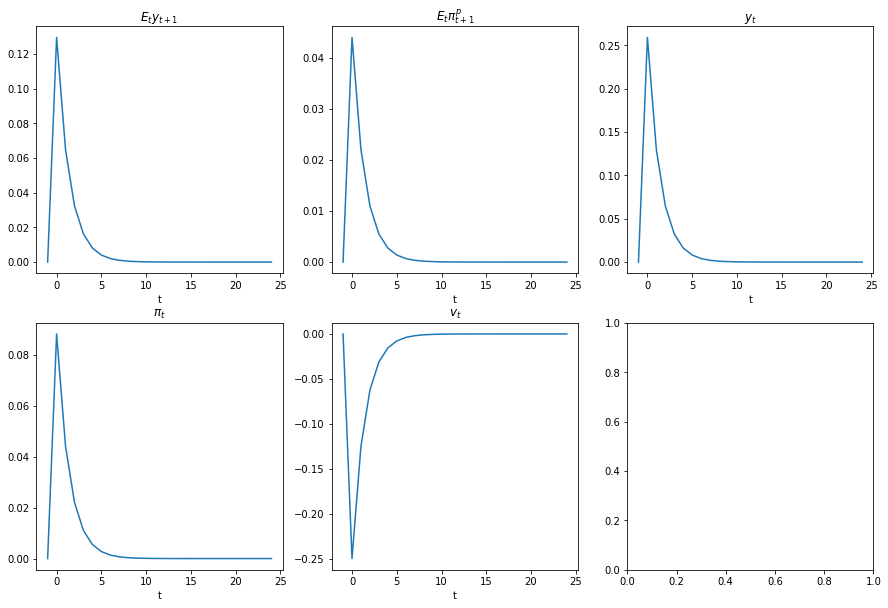

In [39]:
g.impulse_response(z=-0.25)

In [305]:
g.system_symbolic['Gamma_0']

Matrix([
[-1, -1/sigma, \phi_y/sigma + 1, \phi_p/sigma, 1/sigma],
[ 0,    -beta,           -kappa,            1,       0],
[ 0,        0,                1,            0,       0],
[ 0,        0,                0,            1,       0],
[ 0,        0,                0,            0,       1]])

In [306]:
g.calibrate(calibration)

In [307]:
g.system_numeric['Gamma_0']

array([[-1.        , -1.        ,  1.125     ,  1.5       ,  1.        ],
       [ 0.        , -0.99      , -0.17166667,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ]])

In [311]:
g.matrix_solution['Theta_0']

array([[-0.51817016],
       [-0.17614365],
       [-1.03634032],
       [-0.3522873 ],
       [ 1.        ]])

In [272]:
g=Gensys(parameters='na',variables=var,shocks='na', equations=eq)
g.get_matrices(eq,var_, z, eta)
g.calibrate(calibration)
g.solve(method='qz')

C:\Users\MBBar\AppData\Local\Temp/ipykernel_29520/1868341914.py:144: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


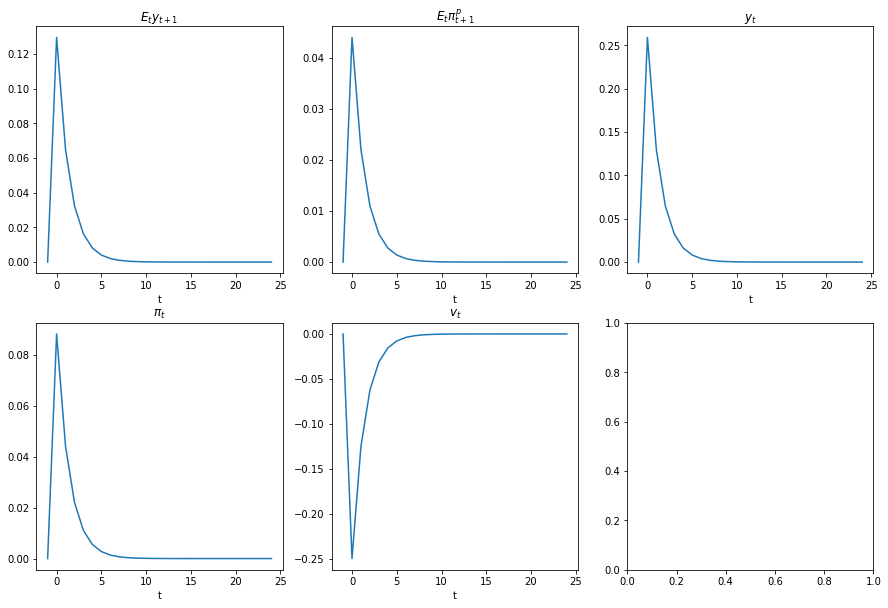

In [273]:
g.impulse_response(z=-0.25)

## Galí Sticky Wage

In [278]:
E_y, E_pi_p, E_pi_w, y_, pi_p_, pi_w_, w_= symbols('E_{t-1}y_t E_{t-1}\pi^p_t E_{t-1}\pi^w_t y_{t-1} \pi^p_{t-1} \pi^w_{t-1} \omega_{t-1}')
Ey1, Epi_p1, Epi_w1, y, pi_p, pi_w, w = symbols('E_ty_{t+1} E_t\pi^p_{t+1} E_t\pi^w_{t+1} y_t \pi^p_t \pi^w_t \omega_t')
phi_y, phi_p, phi_w =symbols('phi_y phi_p phi_w')
lam_p, lam_w = symbols('lambda_p lambda_w')
sigma, kappa, beta, rho = symbols('sigma, kappa, beta, rho')
eta_y, eta_pi_p, eta_pi_w = symbols('\eta_y, \eta_{\pi^p}, \eta_{\pi^w}')
chi_p, chi_w = symbols('chi_p chi_w')
v, v_ = symbols('v_t, v_{t-1}')
rho_v = symbols('\\rho_v')
eps_v = symbols('\epsilon_v')

In [279]:
i=rho+phi_p*pi_p+phi_w*pi_w+phi_y*y+v

eq=[
    Eq(y, Ey1-1/sigma*(i-Epi_p1-rho)),      #IS curve
    Eq(pi_p, beta*Epi_p1+chi_p*y+lam_p*w),  #Price NKPC
    Eq(pi_w, beta*Epi_w1+chi_w*y-lam_w*w),  #Price NKPC
    Eq(w, w_+pi_w-pi_p),                    #Real wage gap
    Eq(v, rho_v*v_+eps_v),                  #V
    Eq(y, E_y+eta_y),                       # Expectation error for y
    Eq(pi_p, E_pi_p+eta_pi_p),              #Expectation error for pi^p
    Eq(pi_w, E_pi_w+eta_pi_w)               #Expectation error for pi^w
]

In [280]:
var  = Ey1, Epi_p1, Epi_w1, y, pi_p, pi_w, w, v
var_ = E_y, E_pi_p, E_pi_w, y_, pi_p_, pi_w_, w_, v_
z = eps_v,
eta = eta_y, eta_pi_p, eta_pi_w

In [281]:
calibration={'beta':0.99, 'phi':5, 'alpha':1/4, 'sigma':1,
             'eps_p':9, 'eps_w':4.5,
             'phi_p':1.5, 'phi_y':0.5/4, 'phi_w':0, '\\rho_v':0.5,
             'theta_p':0.01, 'theta_w':3/4}

calibration['Theta']=(1-calibration['alpha'])/(1-calibration['alpha']+calibration['alpha']*calibration['eps_p'])
calibration['lambda_p']=(1-calibration['theta_p'])*(1-calibration['beta']*calibration['theta_p'])/calibration['theta_p']*calibration['Theta']
calibration['lambda_w']= (1-calibration['theta_w'])*(1-calibration['beta']*calibration['theta_w'])/(calibration['theta_w']*(1+calibration['eps_w']*calibration['phi']))

calibration['chi_p']=calibration['alpha']*calibration['lambda_p']*(1-calibration['alpha'])
calibration['chi_w']=calibration['lambda_w']*(calibration['sigma']+calibration['phi']/(1-calibration['alpha']))


In [283]:
g=Gensys(parameters='na',variables=var,shocks='na', equations=eq)
g.get_matrices(equations, var_, z, eta)
g.calibrate(calibration)
g.solve(method='qz')

C:\Users\MBBar\AppData\Local\Temp/ipykernel_29520/1868341914.py:144: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


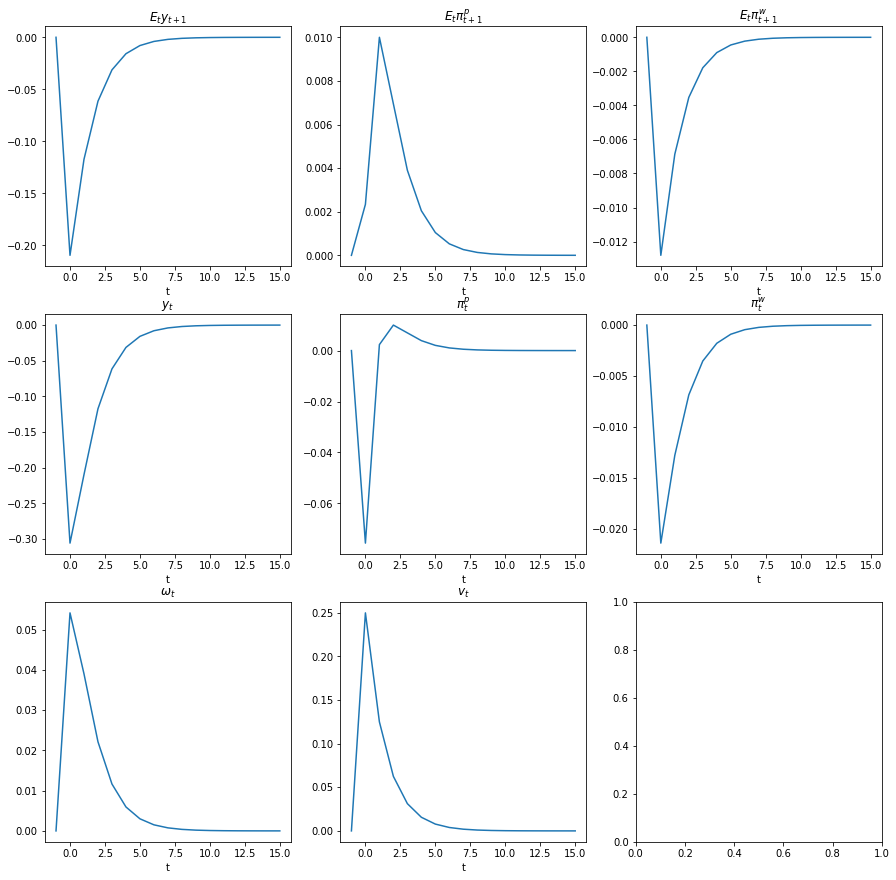

In [284]:
g.impulse_response(z=0.25, T=16)